In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import plotly.graph_objects as go
from category_encoders import CatBoostEncoder


In [82]:
df=pd.read_csv('bank_data.csv')
df.head()

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1001,NaN,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,1002,NaN,NaN,single,secondary,no,29.0,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,1003,NaN,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,1004,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,1005,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [83]:
df.drop('Id',axis=1,inplace=True)
df['month']=pd.to_datetime(df['month'], format='%b').dt.month.astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        45199 non-null  float64
 1   job        45210 non-null  object 
 2   marital    45211 non-null  object 
 3   education  45211 non-null  object 
 4   default    45211 non-null  object 
 5   balance    45208 non-null  float64
 6   housing    45211 non-null  object 
 7   loan       45211 non-null  object 
 8   contact    45211 non-null  object 
 9   day        45211 non-null  int64  
 10  month      45211 non-null  int64  
 11  duration   45211 non-null  int64  
 12  campaign   45211 non-null  int64  
 13  pdays      45211 non-null  int64  
 14  previous   45211 non-null  int64  
 15  poutcome   45211 non-null  object 
 16  y          45211 non-null  object 
dtypes: float64(2), int64(6), object(9)
memory usage: 5.9+ MB


In [84]:
df.duplicated().sum()

0

In [85]:
df.isna().sum()

age          12
job           1
marital       0
education     0
default       0
balance       3
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
y             0
dtype: int64

In [86]:
df.dropna(inplace=True,ignore_index=True)
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

negative age (?)

negative balance (?)

duration 0 (?)

pdays -1 (?)

In [87]:
def covariate_transform(df: pd.DataFrame) -> pd.DataFrame:
    df.age=df.age.apply(lambda x: 18 if x < 18 else x) #assume minimal age of a client is 18 y.o
    df.balance=df.balance.apply(lambda x: 0 if x < 0 else x) #assume there is no minimal balance (?)
    df.duration=df.duration.apply(lambda x: 0 if x < 0 else x) #i'm not really sure what duration means here, but i assume duration must be greater than 0 (?)
    df.pdays=df.pdays.apply(lambda x: 0 if x < 0 else x) #again i'm not really sure what pdays means here, but i assume it means "previous days" (?), so i think it should be greater than 0
    return df

In [88]:
df.y = df.y.apply(lambda x: {'yes': 1, 'no': 0}[x])

In [89]:
df = covariate_transform(df)

In [90]:
cat_cols=list(df.drop(['y'], axis=1).select_dtypes(include='object').columns)
num_cols=list(set(df.columns.values)-set(cat_cols) - set(['y']))

In [91]:
for col in cat_cols:
    print(f'{col}: ', df[col].unique())

job:  ['blue-collar' 'unknown' 'management' 'admin.' 'technician' 'services'
 'retired' 'entrepreneur' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital:  ['married' 'single' 'divorced']
education:  ['unknown' 'tertiary' 'secondary' 'primary']
default:  ['no' 'yes']
housing:  ['yes' 'no']
loan:  ['no' 'yes']
contact:  ['unknown' 'cellular' 'telephone']
poutcome:  ['unknown' 'failure' 'other' 'success']


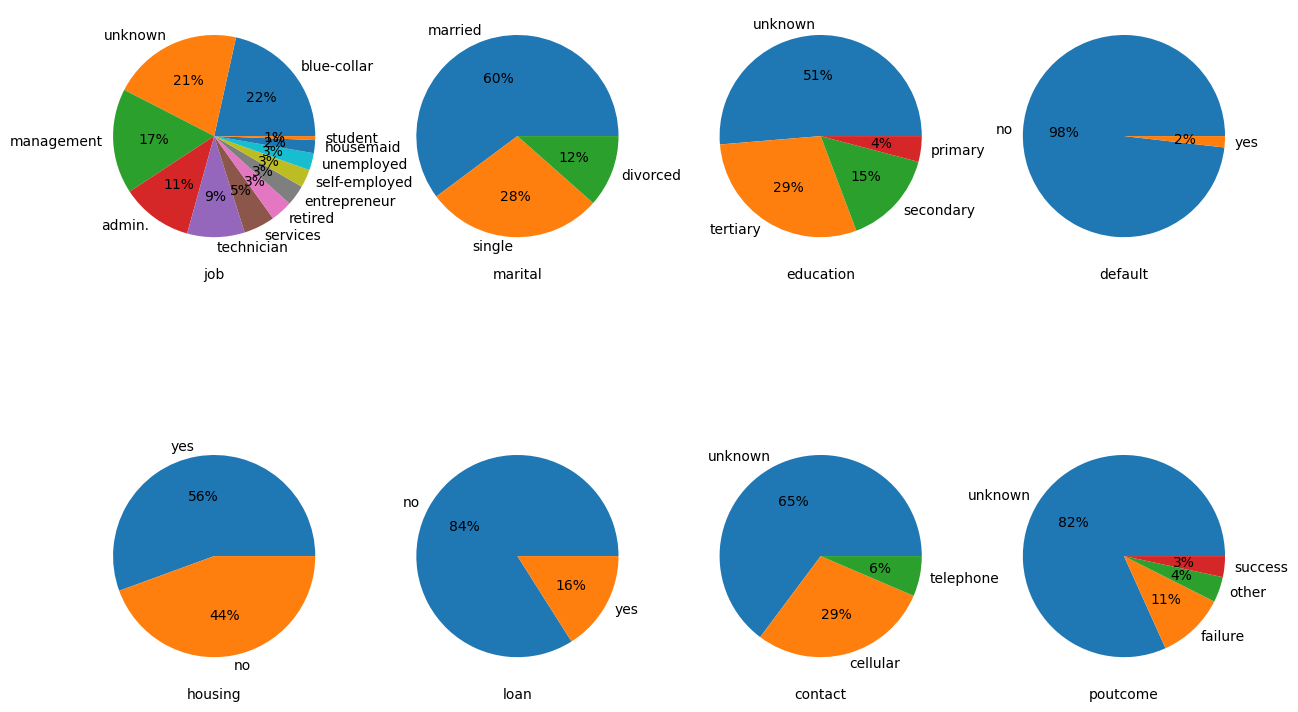

In [92]:
_, ax = plt.subplots(2, 4, figsize=(15,10))
for i, cat_col in enumerate(cat_cols):
    fracs=list(df[cat_col].value_counts().values)
    ax[i//4, i%4].pie(x=fracs, labels=df[cat_col].unique(), autopct='%.0f%%')
    ax[i//4, i%4].set_xlabel(cat_col)

<Axes: >

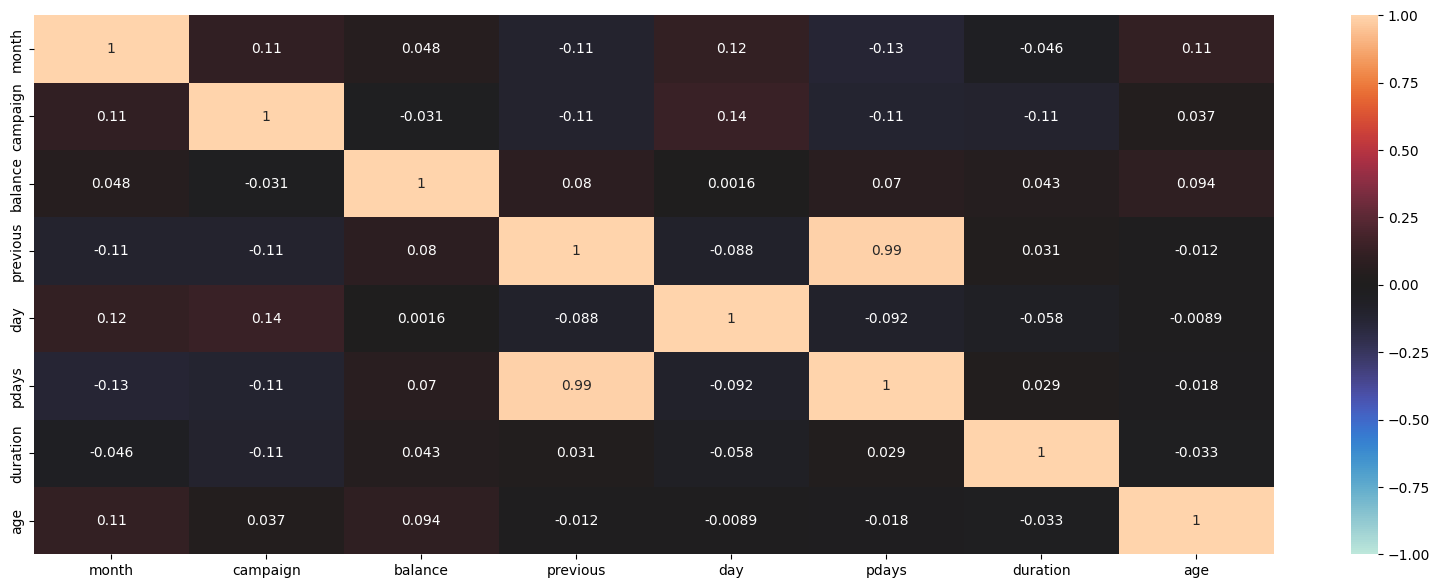

In [93]:
plt.figure(figsize=(20, 7))
sns.heatmap(df.loc[:,num_cols].corr(method='spearman'), vmin=-1, vmax=1, center=0, annot=True)

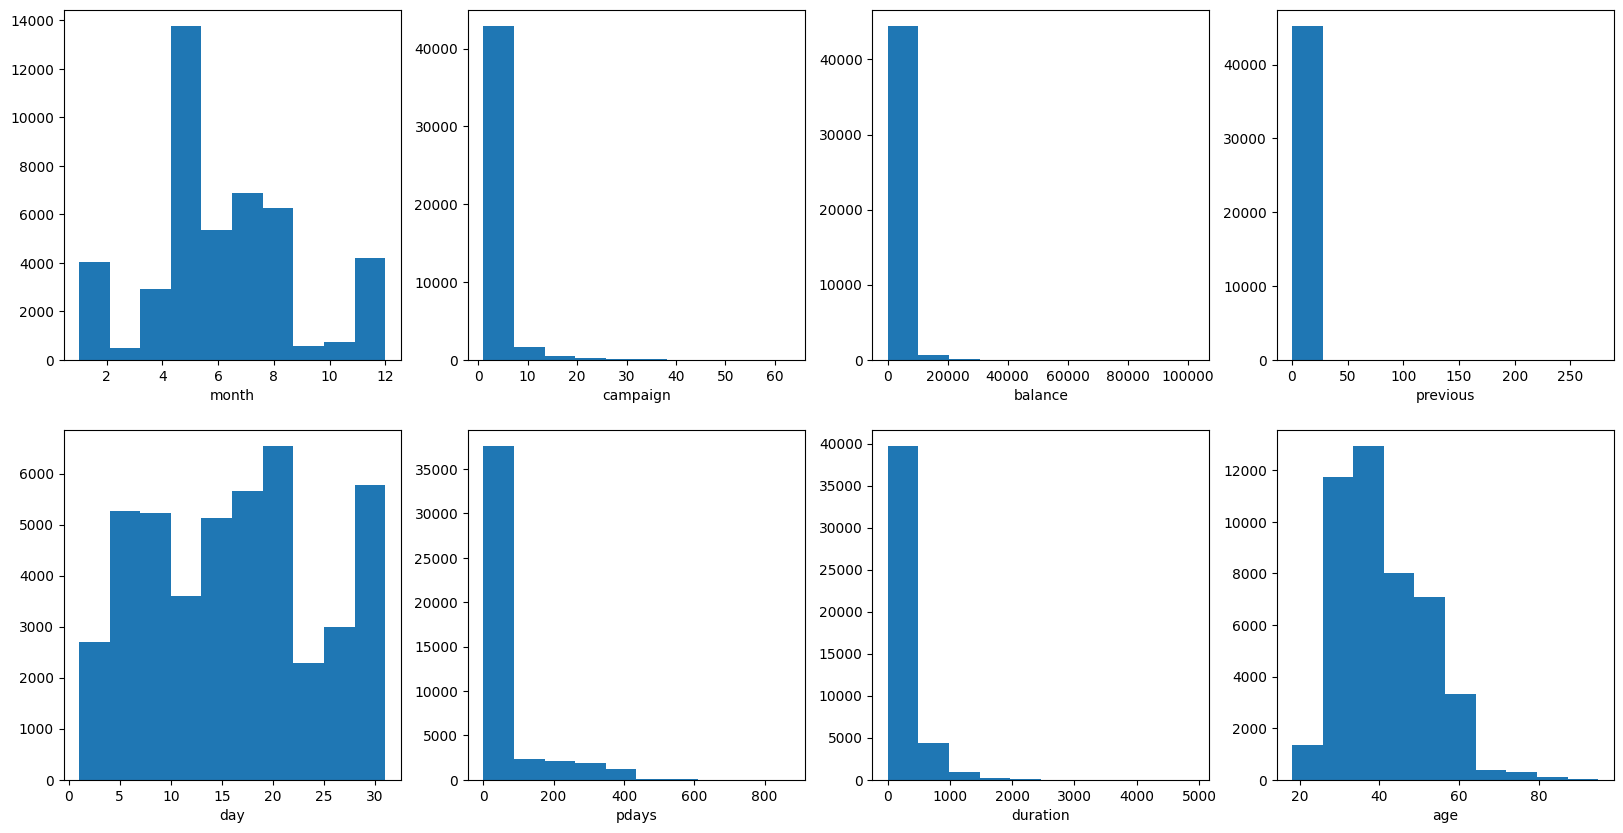

In [94]:
_, ax = plt.subplots(2, 4, figsize=(20,10))
for i, num_col in enumerate(num_cols):
    ax[i//4, i%4].hist(df[num_col])
    ax[i//4, i%4].set_xlabel(num_col)

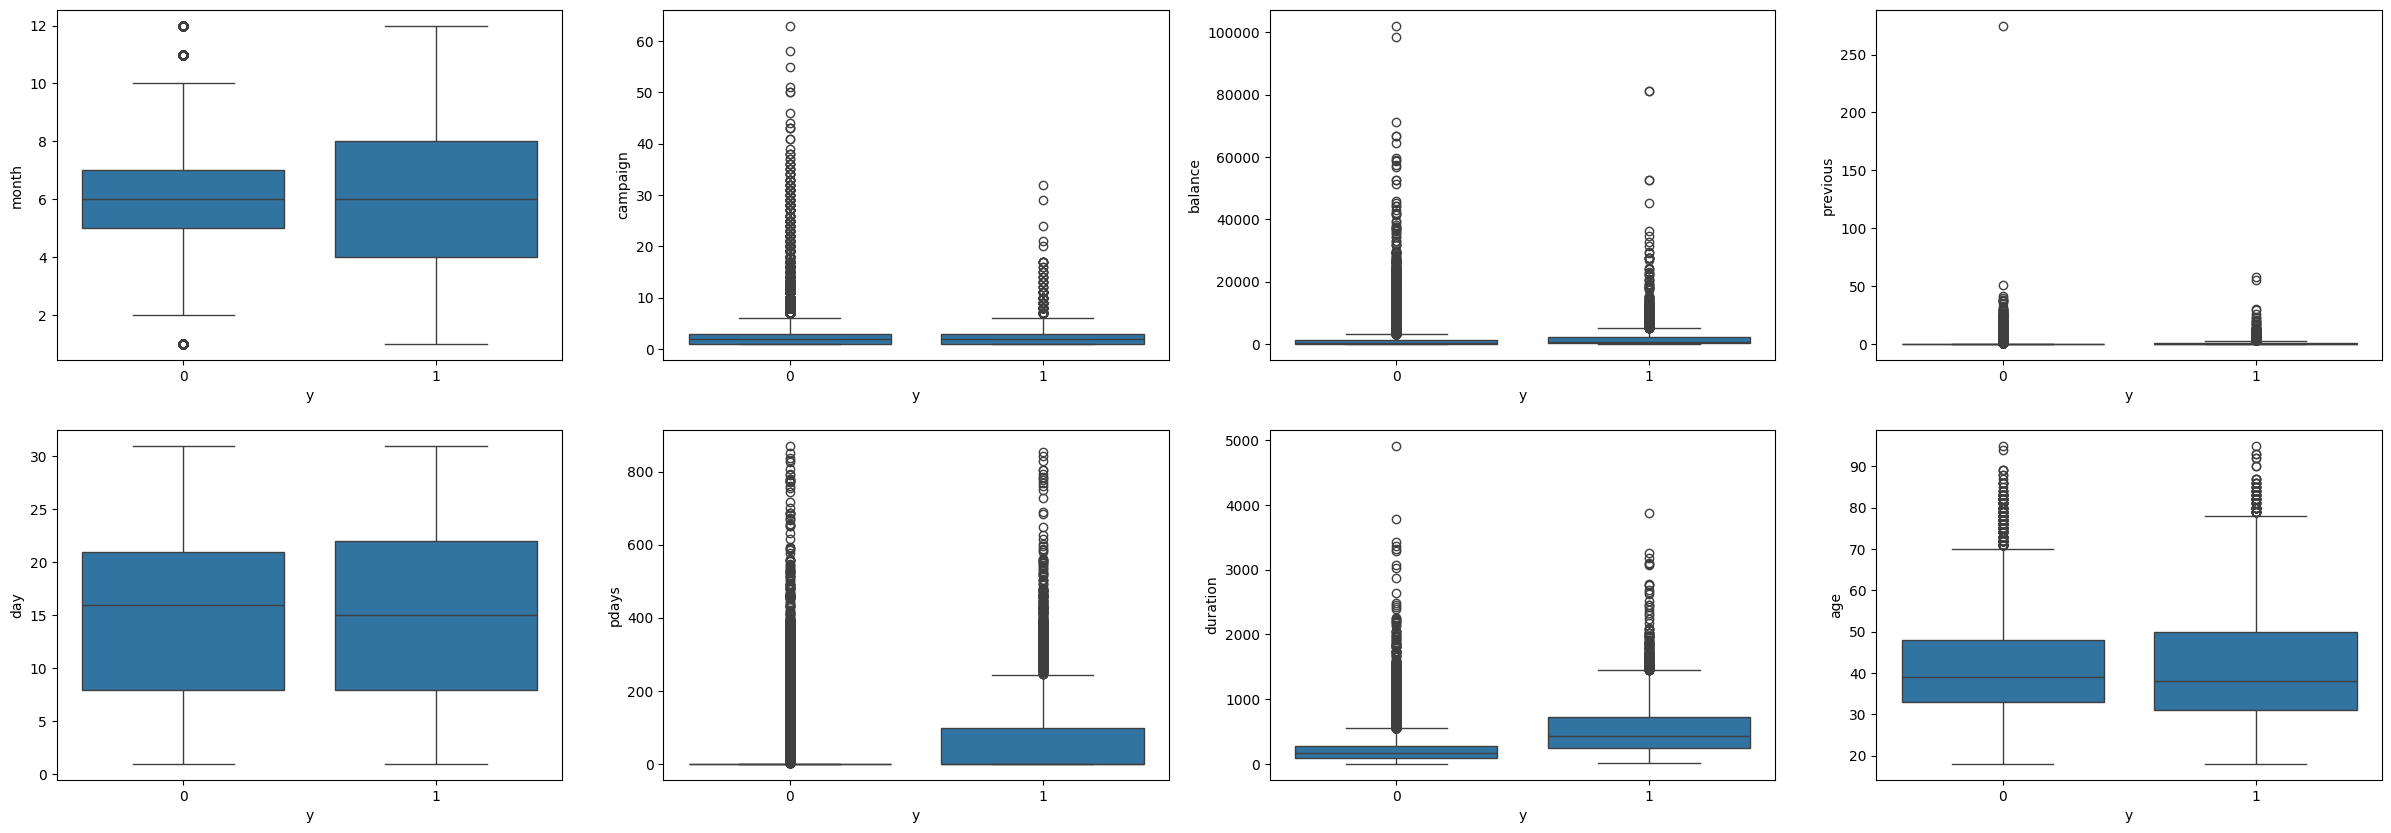

In [95]:
_, ax = plt.subplots(2, 4, figsize=(30,10))
for i, num_col in enumerate(num_cols):
    sns.boxplot(x=df.y ,y=df[num_col],ax=ax[i//4, i%4])

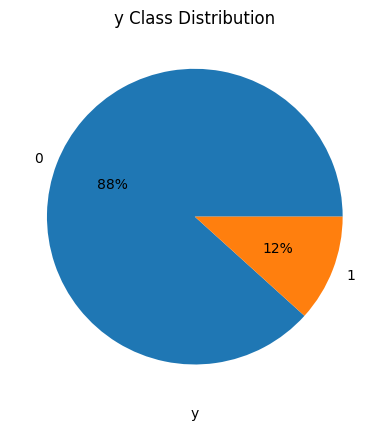

In [96]:
plt.pie(x=df.y.value_counts().values, labels=df.y.unique(), autopct='%.0f%%')
plt.xlabel('y')
plt.title('y Class Distribution')
plt.show()

In [97]:
df.job.value_counts()

job
blue-collar      9730
management       9456
technician       7594
admin.           5169
services         4153
retired          2263
self-employed    1579
entrepreneur     1484
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

In [98]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['y'], axis=1), df.y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [99]:
# Catboost encoding
encoder = CatBoostEncoder(cols=cat_cols, return_df=True)
x_train = encoder.fit_transform(x_train, y_train)
x_test = encoder.fit_transform(x_test, y_test)
x_val = encoder.fit_transform(x_val, y_val)

In [100]:
scaler=MinMaxScaler()
scaler.set_output(transform='pandas')
sm = ADASYN(n_neighbors=10, random_state=42)
cv = StratifiedKFold(5, shuffle=True, random_state=42)

In [101]:
def objective(trial):
    depth=trial.suggest_int("max_depth",6,20,step=1)
    estimators=trial.suggest_int("n_estimators",100,900,step=100)
    subsample=trial.suggest_float("subsample",0.5,1,step=0.1)
    colsample=trial.suggest_float("colsample_bytree",0.5,1,step=0.1)
    reg_alpha=trial.suggest_float("reg_alpha",0,2e-1,step=0.025)
    reg_lambda=trial.suggest_float("reg_lambda",0,2e-1,step=0.025)
    leaves=trial.suggest_int("num_leaves",12,40,step=2)
    lr=trial.suggest_float("learning_rate",0.05,0.3,step=0.05)
    bin_sample=trial.suggest_int("subsample_for_bin",200000,400000,step=16)

    model=LGBMClassifier(num_leaves=leaves,
                         max_depth=depth,
                         learning_rate=lr,
                         n_estimators=estimators,
                         subsample=subsample,
                         colsample_bytree=colsample,
                         reg_alpha=reg_alpha,
                         reg_lambda=reg_lambda,
                         subsample_for_bin=bin_sample,
                         n_jobs=-1,
                         random_state=42,                        
                        )
    scores=[]
    for fold, (train, val) in enumerate(cv.split(x_train, y_train)):
        X, y= x_train.copy(), y_train.copy()
        x_train1, y_train1, x_val1, y_val1 = X.iloc[train], y.iloc[train], X.iloc[val], y.iloc[val]
        x_train1 = scaler.fit_transform(x_train1)
        x_val1 = scaler.transform(x_val1)
        x_train1, y_train1 = sm.fit_resample(x_train1, y_train1)
        model.fit(x_train1, y_train1, eval_metric='auc',
                  eval_set=[(x_val, y_val)], callbacks=[early_stopping(100)])
        scores.append(f1_score(y_val1, model.predict(x_val1)))
    return np.mean(scores)

In [102]:
sampler=optuna.samplers.TPESampler(seed=42)
study=optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-04-13 00:28:22,012] A new study created in memory with name: no-name-8a212ebd-abd4-414c-aef6-5eda26e5998a


[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.86254
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 37739, number of used featu

[I 2024-04-13 00:28:25,301] Trial 0 finished with value: 0.45285178404063026 and parameters: {'max_depth': 11, 'n_estimators': 900, 'subsample': 0.9, 'colsample_bytree': 0.8, 'reg_alpha': 0.025, 'reg_lambda': 0.025, 'num_leaves': 12, 'learning_rate': 0.3, 'subsample_for_bin': 320224}. Best is trial 0 with value: 0.45285178404063026.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.861962
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's auc: 0.64496	valid_0's binary_logloss: 1.9613
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM

[I 2024-04-13 00:28:28,776] Trial 1 finished with value: 0.5723179995206059 and parameters: {'max_depth': 16, 'n_estimators': 100, 'subsample': 1.0, 'colsample_bytree': 0.9, 'reg_alpha': 0.025, 'reg_lambda': 0.025, 'num_leaves': 16, 'learning_rate': 0.1, 'subsample_for_bin': 304944}. Best is trial 1 with value: 0.5723179995206059.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.661742	valid_0's binary_logloss: 1.41024
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5002	valid_0's binary_logloss: 0.831723
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And

[I 2024-04-13 00:28:32,463] Trial 2 finished with value: 0.5091909834190637 and parameters: {'max_depth': 12, 'n_estimators': 300, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 0.05, 'reg_lambda': 0.07500000000000001, 'num_leaves': 24, 'learning_rate': 0.25, 'subsample_for_bin': 239936}. Best is trial 1 with value: 0.5723179995206059.


Early stopping, best iteration is:
[2]	valid_0's auc: 0.646875	valid_0's binary_logloss: 0.790661
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.535707	valid_0's binary_logloss: 0.844424
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

[I 2024-04-13 00:28:36,500] Trial 3 finished with value: 0.521152395119266 and parameters: {'max_depth': 13, 'n_estimators': 600, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_alpha': 0.025, 'reg_lambda': 0.0, 'num_leaves': 40, 'learning_rate': 0.3, 'subsample_for_bin': 361680}. Best is trial 1 with value: 0.5723179995206059.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.535181	valid_0's binary_logloss: 0.836672
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's auc: 0.624789	valid_0's binary_logloss: 1.83277
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

[I 2024-04-13 00:28:39,609] Trial 4 finished with value: 0.559841359079776 and parameters: {'max_depth': 10, 'n_estimators': 100, 'subsample': 0.9, 'colsample_bytree': 0.7, 'reg_alpha': 0.025, 'reg_lambda': 0.1, 'num_leaves': 12, 'learning_rate': 0.3, 'subsample_for_bin': 251760}. Best is trial 1 with value: 0.5723179995206059.


Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.685526	valid_0's binary_logloss: 1.23702
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.535707	valid_0's binary_logloss: 0.817131
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

[I 2024-04-13 00:28:43,396] Trial 5 finished with value: 0.5170186734192462 and parameters: {'max_depth': 15, 'n_estimators': 300, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.025, 'reg_lambda': 0.2, 'num_leaves': 34, 'learning_rate': 0.3, 'subsample_for_bin': 378976}. Best is trial 1 with value: 0.5723179995206059.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.535707	valid_0's binary_logloss: 0.836538
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5002	valid_0's binary_logloss: 0.743181
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

[I 2024-04-13 00:28:46,769] Trial 6 finished with value: 0.4969145235241048 and parameters: {'max_depth': 14, 'n_estimators': 900, 'subsample': 0.5, 'colsample_bytree': 0.6, 'reg_alpha': 0.0, 'reg_lambda': 0.05, 'num_leaves': 22, 'learning_rate': 0.1, 'subsample_for_bin': 365760}. Best is trial 1 with value: 0.5723179995206059.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.5002	valid_0's binary_logloss: 0.743852
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.499516	valid_0's binary_logloss: 0.831819
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

[I 2024-04-13 00:28:50,450] Trial 7 finished with value: 0.5034724746390217 and parameters: {'max_depth': 11, 'n_estimators': 300, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 0.17500000000000002, 'reg_lambda': 0.0, 'num_leaves': 40, 'learning_rate': 0.25, 'subsample_for_bin': 239744}. Best is trial 1 with value: 0.5723179995206059.


Early stopping, best iteration is:
[4]	valid_0's auc: 0.67439	valid_0's binary_logloss: 0.964755
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.71278
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

[I 2024-04-13 00:28:53,794] Trial 8 finished with value: 0.4564929147444795 and parameters: {'max_depth': 6, 'n_estimators': 800, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_alpha': 0.15000000000000002, 'reg_lambda': 0.0, 'num_leaves': 22, 'learning_rate': 0.05, 'subsample_for_bin': 372624}. Best is trial 1 with value: 0.5723179995206059.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.535707	valid_0's binary_logloss: 0.711615
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.499516	valid_0's binary_logloss: 0.863521
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

[I 2024-04-13 00:28:57,485] Trial 9 finished with value: 0.5193281431089097 and parameters: {'max_depth': 15, 'n_estimators': 300, 'subsample': 0.5, 'colsample_bytree': 0.6, 'reg_alpha': 0.05, 'reg_lambda': 0.15000000000000002, 'num_leaves': 30, 'learning_rate': 0.3, 'subsample_for_bin': 294448}. Best is trial 1 with value: 0.5723179995206059.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.499516	valid_0's binary_logloss: 0.856362
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.602599	valid_0's binary_logloss: 1.64801
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

[I 2024-04-13 00:29:00,886] Trial 10 finished with value: 0.5768910635929585 and parameters: {'max_depth': 20, 'n_estimators': 100, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.15000000000000002, 'num_leaves': 18, 'learning_rate': 0.15000000000000002, 'subsample_for_bin': 295856}. Best is trial 10 with value: 0.5768910635929585.


Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.639875	valid_0's binary_logloss: 1.53486
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.602599	valid_0's binary_logloss: 1.64801
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_col_wise=true` to remove the

[I 2024-04-13 00:29:04,351] Trial 11 finished with value: 0.5768910635929585 and parameters: {'max_depth': 20, 'n_estimators': 100, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.15000000000000002, 'num_leaves': 18, 'learning_rate': 0.15000000000000002, 'subsample_for_bin': 296688}. Best is trial 10 with value: 0.5768910635929585.


Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.639875	valid_0's binary_logloss: 1.53486
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.602599	valid_0's binary_logloss: 1.64801
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_col_wise=true` to remove the

[I 2024-04-13 00:29:07,753] Trial 12 finished with value: 0.5768910635929585 and parameters: {'max_depth': 20, 'n_estimators': 100, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.15000000000000002, 'num_leaves': 18, 'learning_rate': 0.15000000000000002, 'subsample_for_bin': 278912}. Best is trial 10 with value: 0.5768910635929585.


Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.639875	valid_0's binary_logloss: 1.53486
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.788354
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

[I 2024-04-13 00:29:11,167] Trial 13 finished with value: 0.4757626087370788 and parameters: {'max_depth': 20, 'n_estimators': 500, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.15000000000000002, 'num_leaves': 18, 'learning_rate': 0.2, 'subsample_for_bin': 333872}. Best is trial 10 with value: 0.5768910635929585.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.787373
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.762125
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

[I 2024-04-13 00:29:14,859] Trial 14 finished with value: 0.4926703841271741 and parameters: {'max_depth': 18, 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.125, 'reg_lambda': 0.2, 'num_leaves': 28, 'learning_rate': 0.15000000000000002, 'subsample_for_bin': 276928}. Best is trial 10 with value: 0.5768910635929585.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.535707	valid_0's binary_logloss: 0.749976
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.80056
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tot

[I 2024-04-13 00:29:18,165] Trial 15 finished with value: 0.4404233928447832 and parameters: {'max_depth': 18, 'n_estimators': 200, 'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 0.07500000000000001, 'reg_lambda': 0.125, 'num_leaves': 16, 'learning_rate': 0.2, 'subsample_for_bin': 336944}. Best is trial 10 with value: 0.5768910635929585.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.787373
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.736933
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

[I 2024-04-13 00:29:21,974] Trial 16 finished with value: 0.4764239614163147 and parameters: {'max_depth': 18, 'n_estimators': 200, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.125, 'reg_lambda': 0.17500000000000002, 'num_leaves': 20, 'learning_rate': 0.1, 'subsample_for_bin': 202624}. Best is trial 10 with value: 0.5768910635929585.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.738433
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.762124
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

[I 2024-04-13 00:29:25,544] Trial 17 finished with value: 0.47885307426545226 and parameters: {'max_depth': 20, 'n_estimators': 600, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_alpha': 0.17500000000000002, 'reg_lambda': 0.1, 'num_leaves': 26, 'learning_rate': 0.15000000000000002, 'subsample_for_bin': 261488}. Best is trial 10 with value: 0.5768910635929585.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.535707	valid_0's binary_logloss: 0.749981
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.715743
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

[I 2024-04-13 00:29:28,857] Trial 18 finished with value: 0.46786322905253386 and parameters: {'max_depth': 17, 'n_estimators': 400, 'subsample': 0.6, 'colsample_bytree': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.125, 'num_leaves': 14, 'learning_rate': 0.05, 'subsample_for_bin': 303984}. Best is trial 10 with value: 0.5768910635929585.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.718967
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.535707	valid_0's binary_logloss: 0.771696
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

[I 2024-04-13 00:29:32,568] Trial 19 finished with value: 0.49420955632492214 and parameters: {'max_depth': 19, 'n_estimators': 200, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.2, 'reg_lambda': 0.17500000000000002, 'num_leaves': 32, 'learning_rate': 0.2, 'subsample_for_bin': 208672}. Best is trial 10 with value: 0.5768910635929585.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.535707	valid_0's binary_logloss: 0.785077
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.647855	valid_0's binary_logloss: 1.74206
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

[I 2024-04-13 00:29:35,937] Trial 20 finished with value: 0.5483473796138967 and parameters: {'max_depth': 7, 'n_estimators': 100, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_alpha': 0.07500000000000001, 'reg_lambda': 0.125, 'num_leaves': 20, 'learning_rate': 0.1, 'subsample_for_bin': 398784}. Best is trial 10 with value: 0.5768910635929585.


Did not meet early stopping. Best iteration is:
[41]	valid_0's auc: 0.669162	valid_0's binary_logloss: 1.55388
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's auc: 0.602659	valid_0's binary_logloss: 1.64803
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001822 seconds.
You can set `force_col_wise=true` to remove the

[I 2024-04-13 00:29:39,340] Trial 21 finished with value: 0.5750762062625461 and parameters: {'max_depth': 20, 'n_estimators': 100, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.125, 'reg_lambda': 0.15000000000000002, 'num_leaves': 18, 'learning_rate': 0.15000000000000002, 'subsample_for_bin': 283824}. Best is trial 10 with value: 0.5768910635929585.


Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.643224	valid_0's binary_logloss: 1.78955
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.76213
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Li

[I 2024-04-13 00:29:42,698] Trial 22 finished with value: 0.46717579974206325 and parameters: {'max_depth': 19, 'n_estimators': 200, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.07500000000000001, 'reg_lambda': 0.17500000000000002, 'num_leaves': 16, 'learning_rate': 0.15000000000000002, 'subsample_for_bin': 272128}. Best is trial 10 with value: 0.5768910635929585.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.762407
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's auc: 0.586737	valid_0's binary_logloss: 1.57224
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

[I 2024-04-13 00:29:46,523] Trial 23 finished with value: 0.5678399520836408 and parameters: {'max_depth': 17, 'n_estimators': 100, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'num_leaves': 24, 'learning_rate': 0.15000000000000002, 'subsample_for_bin': 319056}. Best is trial 10 with value: 0.5768910635929585.


Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.641241	valid_0's binary_logloss: 1.58078
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.788348
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

[I 2024-04-13 00:29:50,363] Trial 24 finished with value: 0.480519602978725 and parameters: {'max_depth': 19, 'n_estimators': 200, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.15000000000000002, 'reg_lambda': 0.15000000000000002, 'num_leaves': 20, 'learning_rate': 0.2, 'subsample_for_bin': 283808}. Best is trial 10 with value: 0.5768910635929585.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.787376
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.736935
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

[I 2024-04-13 00:29:54,107] Trial 25 finished with value: 0.4588575397719592 and parameters: {'max_depth': 17, 'n_estimators': 400, 'subsample': 0.9, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.17500000000000002, 'num_leaves': 14, 'learning_rate': 0.1, 'subsample_for_bin': 345552}. Best is trial 10 with value: 0.5768910635929585.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.738433
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.582732	valid_0's binary_logloss: 1.8729
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Li

[I 2024-04-13 00:29:57,858] Trial 26 finished with value: 0.5843822115622966 and parameters: {'max_depth': 20, 'n_estimators': 100, 'subsample': 1.0, 'colsample_bytree': 0.9, 'reg_alpha': 0.125, 'reg_lambda': 0.125, 'num_leaves': 18, 'learning_rate': 0.15000000000000002, 'subsample_for_bin': 316848}. Best is trial 26 with value: 0.5843822115622966.


Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.65044	valid_0's binary_logloss: 1.47658
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.815597
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Li

[I 2024-04-13 00:30:01,440] Trial 27 finished with value: 0.4929560651943632 and parameters: {'max_depth': 9, 'n_estimators': 400, 'subsample': 0.8, 'colsample_bytree': 0.9, 'reg_alpha': 0.15000000000000002, 'reg_lambda': 0.125, 'num_leaves': 24, 'learning_rate': 0.25, 'subsample_for_bin': 318272}. Best is trial 26 with value: 0.5843822115622966.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.813324
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.80056
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tot

[I 2024-04-13 00:30:04,745] Trial 28 finished with value: 0.447639729373961 and parameters: {'max_depth': 16, 'n_estimators': 200, 'subsample': 0.6, 'colsample_bytree': 0.8, 'reg_alpha': 0.125, 'reg_lambda': 0.07500000000000001, 'num_leaves': 14, 'learning_rate': 0.2, 'subsample_for_bin': 298832}. Best is trial 26 with value: 0.5843822115622966.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.535581	valid_0's binary_logloss: 0.787377
[LightGBM] [Info] Number of positive: 18973, number of negative: 19145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 38118, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497744 -> initscore=-0.009025
[LightGBM] [Info] Start training from score -0.009025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.715744
[LightGBM] [Info] Number of positive: 18595, number of negative: 19144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

[I 2024-04-13 00:30:08,102] Trial 29 finished with value: 0.46045393063619244 and parameters: {'max_depth': 19, 'n_estimators': 700, 'subsample': 0.9, 'colsample_bytree': 0.8, 'reg_alpha': 0.07500000000000001, 'reg_lambda': 0.07500000000000001, 'num_leaves': 12, 'learning_rate': 0.05, 'subsample_for_bin': 326336}. Best is trial 26 with value: 0.5843822115622966.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.718968


In [103]:
study.best_value

0.5843822115622966

In [104]:
best_params=study.best_params
best_params['random_state']=42
best_params['n_jobs']=-1
best_params

{'max_depth': 20,
 'n_estimators': 100,
 'subsample': 1.0,
 'colsample_bytree': 0.9,
 'reg_alpha': 0.125,
 'reg_lambda': 0.125,
 'num_leaves': 18,
 'learning_rate': 0.15000000000000002,
 'subsample_for_bin': 316848,
 'random_state': 42,
 'n_jobs': -1}

In [105]:
x_train=scaler.fit_transform(x_train)
x_train,y_train=sm.fit_resample(x_train,y_train)
x_test=scaler.transform(x_test)

In [106]:
model=LGBMClassifier(**best_params)
model.fit(x_train,y_train, eval_metric='auc', eval_set=[(x_val, y_val)], callbacks=[early_stopping(100)])

[LightGBM] [Info] Number of positive: 23926, number of negative: 23931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 47857, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499948 -> initscore=-0.000209
[LightGBM] [Info] Start training from score -0.000209
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.639583	valid_0's binary_logloss: 1.69266


LGBMClassifier(colsample_bytree=0.9, learning_rate=0.15000000000000002,
               max_depth=20, n_jobs=-1, num_leaves=18, random_state=42,
               reg_alpha=0.125, reg_lambda=0.125, subsample_for_bin=316848)

In [107]:
predict = model.predict(x_test)
print('F1 Score: ', f1_score(y_test, predict))
print('Accuracy Score: ', accuracy_score(y_test, predict))

F1 Score:  0.5727810650887574
Accuracy Score:  0.8801991150442477


In [108]:
def evaluation_parametrics(name,y_val, y_pred):
    
    print("\n------------------------{}------------------------\n".format(name))

    cm_test = confusion_matrix(y_val, y_pred)
    t1 = ConfusionMatrixDisplay(cm_test)    
    print("\nClassification Report\n")
    print(classification_report(y_val, y_pred))   
    print("--------------------------------------------------------------------------")

    t1.plot()


------------------------Confusion Matrix - Test Dataset------------------------


Classification Report

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      7960
           1       0.50      0.67      0.57      1080

    accuracy                           0.88      9040
   macro avg       0.73      0.79      0.75      9040
weighted avg       0.90      0.88      0.89      9040

--------------------------------------------------------------------------


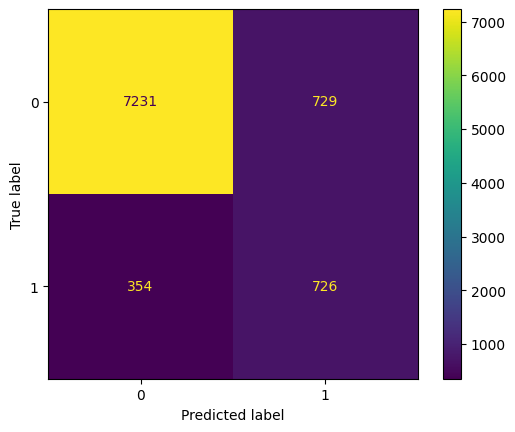

In [109]:
evaluation_parametrics("Confusion Matrix - Test Dataset", y_test, model.predict(x_test))


------------------------Confusion Matrix - Train Dataset------------------------


Classification Report

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     23931
           1       0.94      0.95      0.95     23926

    accuracy                           0.95     47857
   macro avg       0.95      0.95      0.95     47857
weighted avg       0.95      0.95      0.95     47857

--------------------------------------------------------------------------


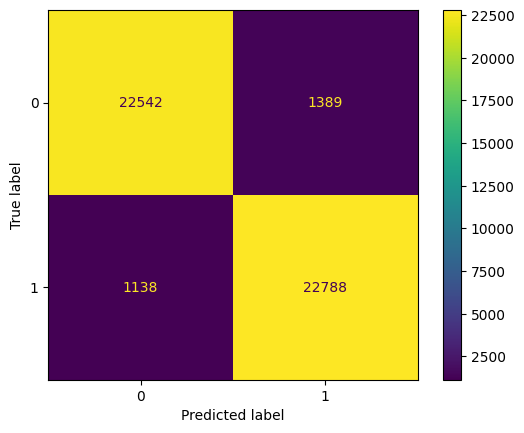

In [110]:
evaluation_parametrics("Confusion Matrix - Train Dataset", y_train, model.predict(x_train))